# Notebook 06: Survival Analysis — Time-to-Default Modeling

**Objective**: Model time-to-default using survival analysis techniques (Cox PH, Random Survival Forest).
Generate **lifetime PD curves** for IFRS 9 Stage 2/3 provisioning.

**Methods**:
1. **Kaplan-Meier** — Non-parametric survival curves by grade
2. **Cox Proportional Hazards** — Semi-parametric: hazard ratios, assumption checks
3. **Random Survival Forest** — Non-parametric, handles non-linear relationships
4. **Lifetime PD curves** — Cumulative default probability over time (for IFRS 9)

**Data**: `loan_master.parquet` (1.35M loans, OOT train only) + raw CSV for `last_pymnt_d`.

In [22]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import time
from pathlib import Path
from loguru import logger

# Survival libraries
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance

# Project imports
import sys
sys.path.insert(0, str(Path("..").resolve()))
from src.models.survival import (
    train_cox_ph, make_survival_target, generate_lifetime_pd_curve
)

# Paths
DATA_DIR = Path("../data/processed")
RAW_DIR = Path("../data/raw")
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Plot style
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
logger.info("NB06 Survival Analysis initialized")

2026-02-08 00:47:02.036 | INFO     | __main__:<module>:40 - NB06 Survival Analysis initialized


---
## 1. Data Loading & Survival Time Construction

Survival analysis requires:
- **Duration (T)**: Time from loan issuance to event/censoring (months)
- **Event (E)**: 1 if default observed, 0 if censored (fully paid or still active)

We extract `last_pymnt_d` from the raw CSV (removed during ETL as leakage) to compute exact duration.

In [23]:
# Load loan_master (training set only — before 2018-01-01)
df_lm = pd.read_parquet(DATA_DIR / "loan_master.parquet")
logger.info(f"loan_master: {df_lm.shape}")

# Read raw CSV for last_pymnt_d (needed for survival time)
logger.info("Reading raw CSV for last_pymnt_d...")
df_raw = pd.read_csv(
    RAW_DIR / "Loan_status_2007-2020Q3.csv",
    usecols=["id", "last_pymnt_d"],
    low_memory=False,
)
df_raw["id"] = df_raw["id"].astype(str)
df_raw["last_pymnt_d"] = pd.to_datetime(df_raw["last_pymnt_d"], format="%b-%Y")

# Merge
df_lm["id"] = df_lm["id"].astype(str)
df = df_lm.merge(df_raw, on="id", how="left")

# Compute time_to_event (months from issue_d to last_pymnt_d)
df["time_to_event"] = ((df["last_pymnt_d"] - df["issue_d"]).dt.days / 30.44).round(0)

# Handle missing last_pymnt_d: use term as censoring time
mask_no_pymnt = df["last_pymnt_d"].isna()
df.loc[mask_no_pymnt, "time_to_event"] = df.loc[mask_no_pymnt, "term"]
df["time_to_event"] = df["time_to_event"].clip(lower=1)

# Event indicator
df["event_observed"] = df["default_flag"].astype(bool)

# Summary
print(f"Survival dataset: {df.shape[0]:,} loans")
print(f"  Events (defaults): {df['event_observed'].sum():,} ({df['event_observed'].mean():.1%})")
print(f"  Censored: {(~df['event_observed']).sum():,}")
print(f"  Time range: {df['time_to_event'].min():.0f} - {df['time_to_event'].max():.0f} months")
print(f"  Median time (defaults): {df.loc[df['event_observed'], 'time_to_event'].median():.0f} months")
print(f"  Median time (censored): {df.loc[~df['event_observed'], 'time_to_event'].median():.0f} months")

2026-02-08 00:47:02.880 | INFO     | __main__:<module>:3 - loan_master: (1346311, 32)
2026-02-08 00:47:02.881 | INFO     | __main__:<module>:6 - Reading raw CSV for last_pymnt_d...


Survival dataset: 1,346,311 loans
  Events (defaults): 249,380 (18.5%)
  Censored: 1,096,931
  Time range: 1 - 70 months
  Median time (defaults): 17 months
  Median time (censored): 29 months


---
## 2. Exploratory Survival Analysis

Visualize the distribution of time-to-event across different risk segments.

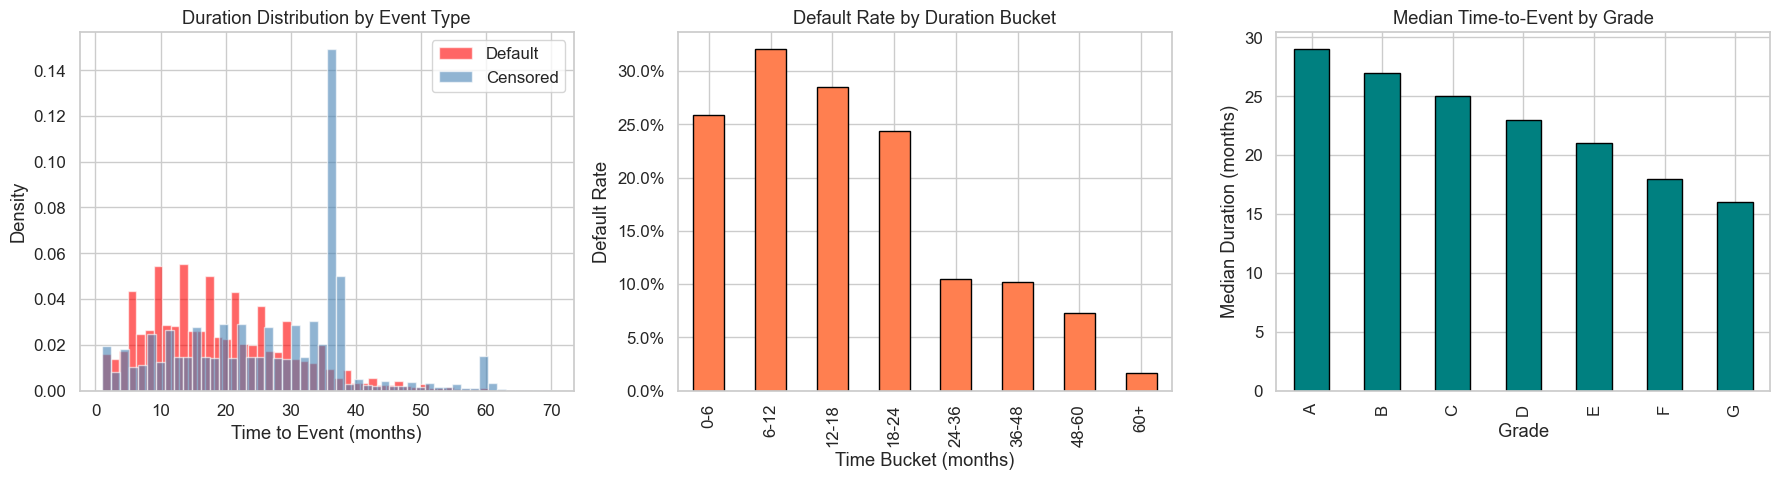

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Duration distribution by event
for evt, label, color in [(True, "Default", "red"), (False, "Censored", "steelblue")]:
    axes[0].hist(df.loc[df["event_observed"] == evt, "time_to_event"],
                 bins=50, alpha=0.6, label=label, color=color, density=True)
axes[0].set_xlabel("Time to Event (months)")
axes[0].set_ylabel("Density")
axes[0].set_title("Duration Distribution by Event Type")
axes[0].legend()

# Default rate by time bucket
df["time_bucket"] = pd.cut(df["time_to_event"], bins=[0, 6, 12, 18, 24, 36, 48, 60, 100],
                           labels=["0-6", "6-12", "12-18", "18-24", "24-36", "36-48", "48-60", "60+"])
default_by_time = df.groupby("time_bucket", observed=True)["default_flag"].mean()
default_by_time.plot(kind="bar", ax=axes[1], color="coral", edgecolor="black")
axes[1].set_xlabel("Time Bucket (months)")
axes[1].set_ylabel("Default Rate")
axes[1].set_title("Default Rate by Duration Bucket")
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Median duration by grade
grade_median = df.groupby("grade")["time_to_event"].median().sort_index()
grade_median.plot(kind="bar", ax=axes[2], color="teal", edgecolor="black")
axes[2].set_xlabel("Grade")
axes[2].set_ylabel("Median Duration (months)")
axes[2].set_title("Median Time-to-Event by Grade")

plt.tight_layout()
plt.show()

---
## 3. Kaplan-Meier Survival Curves

Non-parametric estimation of the survival function $S(t) = P(T > t)$.
We estimate overall portfolio survival and stratify by credit grade.

Portfolio median survival time: 67.0 months
12-month survival: 0.9329
24-month survival: 0.8395
36-month survival: 0.7604


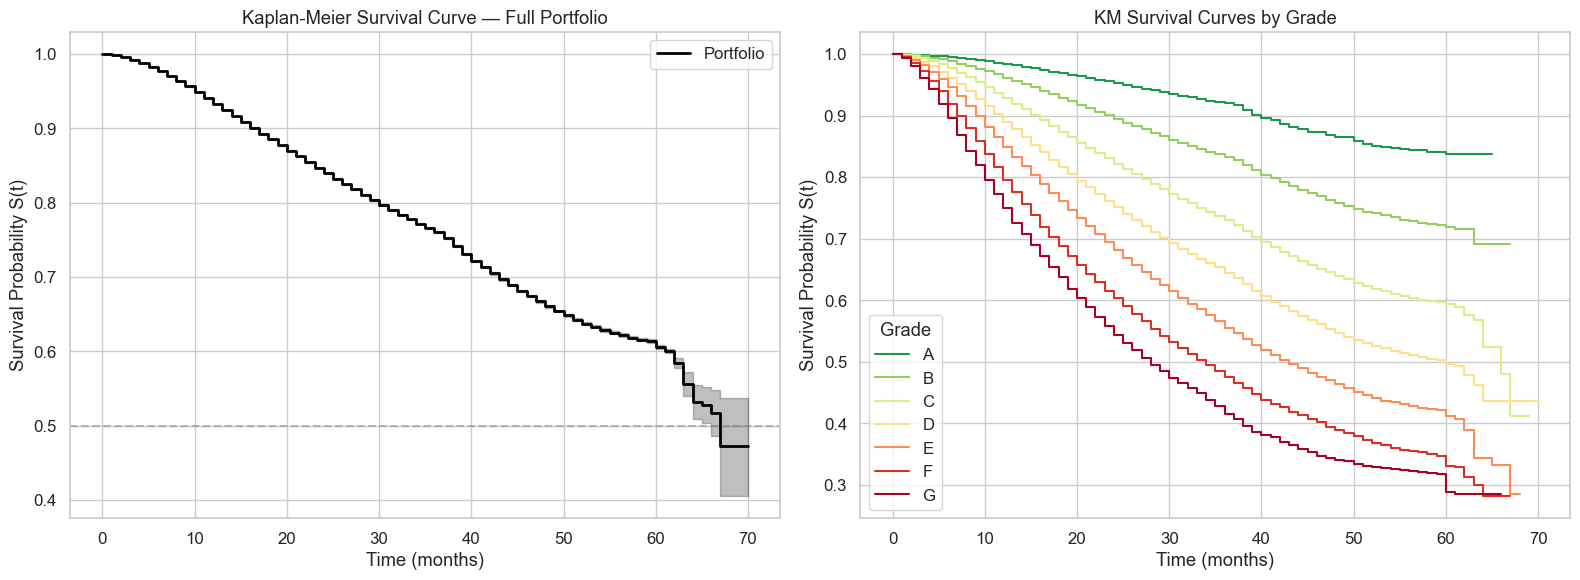

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall KM curve
kmf = KaplanMeierFitter()
kmf.fit(df["time_to_event"], event_observed=df["event_observed"], label="Portfolio")
kmf.plot_survival_function(ax=axes[0], ci_show=True, color="black", linewidth=2)
axes[0].set_xlabel("Time (months)")
axes[0].set_ylabel("Survival Probability S(t)")
axes[0].set_title("Kaplan-Meier Survival Curve — Full Portfolio")
axes[0].axhline(y=0.5, linestyle="--", color="gray", alpha=0.5)

# Median survival time
median_surv = kmf.median_survival_time_
print(f"Portfolio median survival time: {median_surv:.1f} months")
print(f"12-month survival: {kmf.predict(12):.4f}")
print(f"24-month survival: {kmf.predict(24):.4f}")
print(f"36-month survival: {kmf.predict(36):.4f}")

# KM by grade
colors = {"A": "#1a9850", "B": "#91cf60", "C": "#d9ef8b",
          "D": "#fee08b", "E": "#fc8d59", "F": "#d73027", "G": "#a50026"}
for grade in sorted(df["grade"].unique()):
    mask = df["grade"] == grade
    kmf_g = KaplanMeierFitter()
    kmf_g.fit(df.loc[mask, "time_to_event"], event_observed=df.loc[mask, "event_observed"], label=grade)
    kmf_g.plot_survival_function(ax=axes[1], ci_show=False, color=colors.get(grade, "gray"), linewidth=1.5)

axes[1].set_xlabel("Time (months)")
axes[1].set_ylabel("Survival Probability S(t)")
axes[1].set_title("KM Survival Curves by Grade")
axes[1].legend(title="Grade", loc="lower left")

plt.tight_layout()
plt.show()

In [26]:
# Multivariate log-rank test: are survival curves different by grade?
result = multivariate_logrank_test(
    df["time_to_event"], df["grade"], df["event_observed"]
)
print("Multivariate Log-Rank Test (Grade stratification):")
print(f"  Test statistic: {result.test_statistic:.2f}")
print(f"  p-value: {result.p_value:.2e}")
print(f"  Degrees of freedom: {result.degrees_of_freedom}")
if result.p_value < 0.001:
    print("  => Highly significant: survival curves differ by grade")

# Pairwise: A vs G (most extreme)
mask_a = df["grade"] == "A"
mask_g = df["grade"] == "G"
lr_ag = logrank_test(
    df.loc[mask_a, "time_to_event"], df.loc[mask_g, "time_to_event"],
    df.loc[mask_a, "event_observed"], df.loc[mask_g, "event_observed"],
)
print(f"\nPairwise A vs G: statistic={lr_ag.test_statistic:.2f}, p={lr_ag.p_value:.2e}")

Multivariate Log-Rank Test (Grade stratification):
  Test statistic: 84619.66
  p-value: 0.00e+00
  Degrees of freedom: 6
  => Highly significant: survival curves differ by grade

Pairwise A vs G: statistic=23493.03, p=0.00e+00


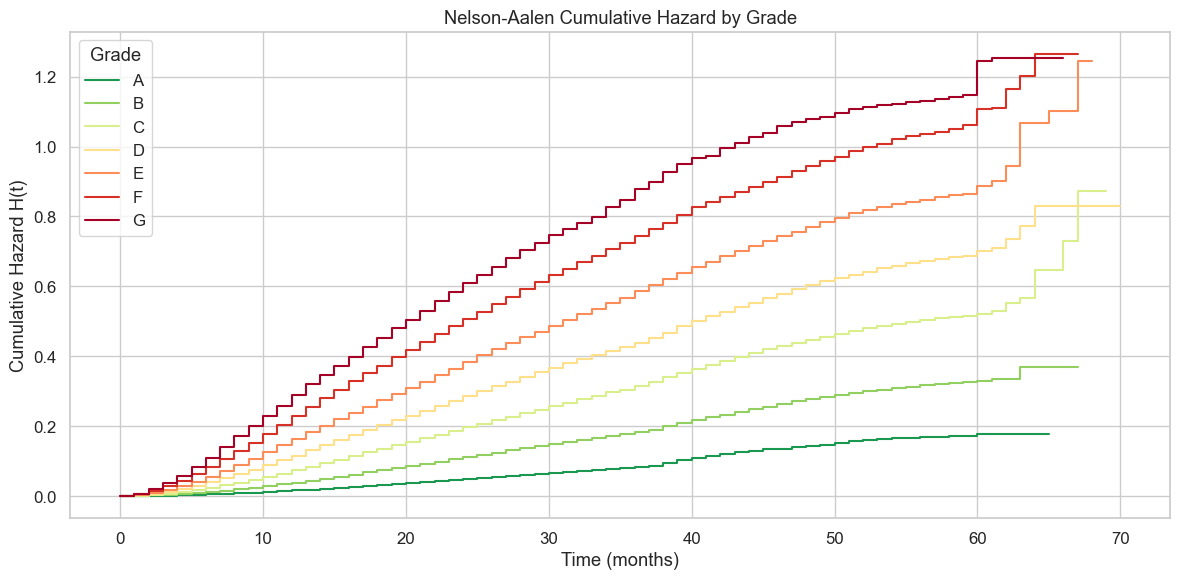

In [27]:
# Nelson-Aalen estimator: cumulative hazard H(t)
fig, ax = plt.subplots(figsize=(12, 6))

for grade in sorted(df["grade"].unique()):
    mask = df["grade"] == grade
    naf = NelsonAalenFitter()
    naf.fit(df.loc[mask, "time_to_event"], event_observed=df.loc[mask, "event_observed"], label=grade)
    naf.plot_cumulative_hazard(ax=ax, ci_show=False, color=colors.get(grade, "gray"), linewidth=1.5)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Cumulative Hazard H(t)")
ax.set_title("Nelson-Aalen Cumulative Hazard by Grade")
ax.legend(title="Grade", loc="upper left")
plt.tight_layout()
plt.show()

---
## 4. Cox Proportional Hazards Model

Semi-parametric model: $h(t|X) = h_0(t) \cdot \exp(\beta^T X)$

The Cox model estimates **hazard ratios** — how each feature multiplicatively affects the risk of default.
Key assumptions: proportional hazards (constant hazard ratios over time).

In [28]:
# Select numeric features for Cox PH (lifelines handles NaN poorly — impute)
cox_features = [
    "loan_amnt", "annual_inc", "int_rate", "dti", "installment",
    "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc",
    "fico_range_low", "credit_history_months", "loan_to_income", "term",
]

# Build Cox dataframe
df_cox = df[cox_features + ["time_to_event", "event_observed"]].copy()

# Impute missing values (Cox PH cannot handle NaN)
for col in cox_features:
    if df_cox[col].isnull().any():
        median_val = df_cox[col].median()
        df_cox[col].fillna(median_val, inplace=True)
        print(f"  Imputed {col}: {df_cox[col].isnull().sum()} -> median={median_val:.2f}")

# Standardize features for stable coefficient estimation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cox[cox_features] = scaler.fit_transform(df_cox[cox_features])

print(f"Cox training data: {df_cox.shape}")
print(f"Events: {df_cox['event_observed'].sum():,}")

  Imputed dti: 0 -> median=17.77
  Imputed revol_util: 0 -> median=53.70
  Imputed loan_to_income: 0 -> median=0.20
Cox training data: (1346311, 16)
Events: 249,380


In [29]:
# Train Cox PH on full data (lifelines is efficient enough)
t0 = time.time()
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_cox, duration_col="time_to_event", event_col="event_observed")
cox_time = time.time() - t0

print(f"Cox PH trained in {cox_time:.1f}s")
print(f"Concordance Index: {cph.concordance_index_:.4f}")
print(f"Partial log-likelihood: {cph.log_likelihood_:.2f}")
print(f"AIC: {cph.AIC_partial_:.2f}")

Cox PH trained in 5.3s
Concordance Index: 0.6769
Partial log-likelihood: -3334574.14
AIC: 6669176.27


Cox PH Summary:
                         coef  exp(coef)  se(coef)         z       p  -log2(p)
covariate                                                                     
loan_amnt             -0.0038     0.9962    0.0057   -0.6688  0.5036    0.9896
annual_inc            -0.0923     0.9119    0.0036  -25.7572  0.0000  483.5794
int_rate               0.4249     1.5294    0.0023  186.3614  0.0000       inf
dti                    0.0387     1.0395    0.0008   48.8561  0.0000       inf
installment            0.0648     1.0670    0.0054   12.0071  0.0000  107.9177
open_acc               0.0559     1.0575    0.0026   21.2412  0.0000  330.2006
pub_rec                0.0204     1.0206    0.0016   12.7588  0.0000  121.4341
revol_bal             -0.0623     0.9396    0.0031  -19.7923  0.0000  287.2146
revol_util            -0.1050     0.9003    0.0024  -44.5795  0.0000       inf
total_acc              0.0031     1.0031    0.0027    1.1322  0.2576    1.9571
fico_range_low        -0.1660     0.

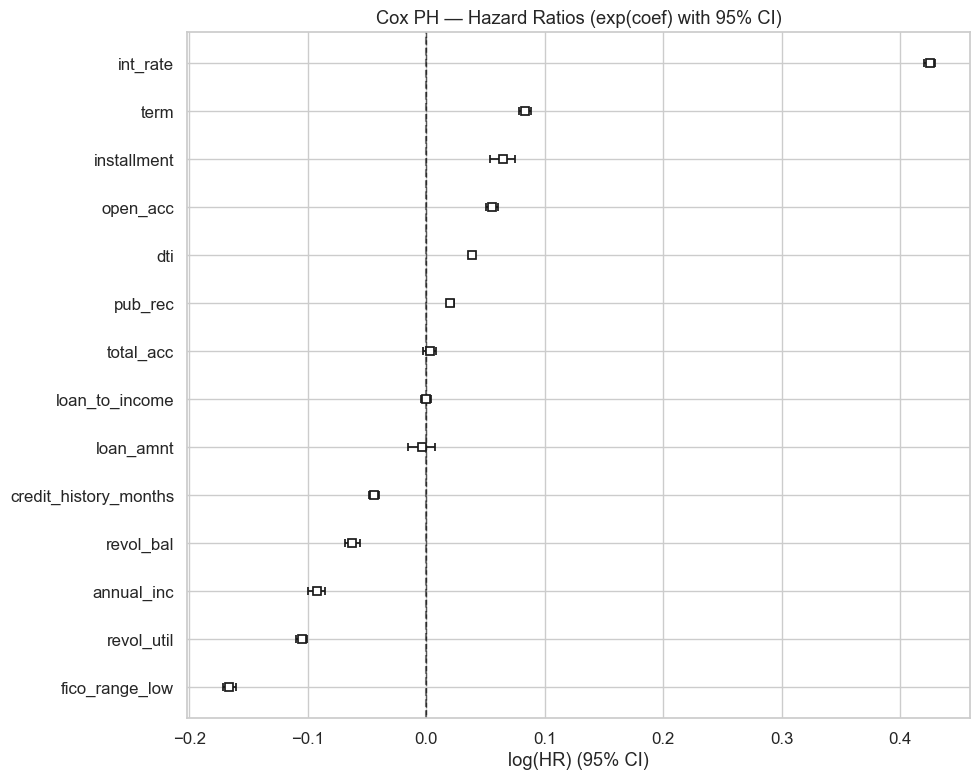


Top 5 risk factors (HR > 1 = increases hazard):
  int_rate: HR = 1.5294
  term: HR = 1.0866
  installment: HR = 1.0670
  open_acc: HR = 1.0575
  dti: HR = 1.0395

Top 5 protective factors (HR < 1 = decreases hazard):
  credit_history_months: HR = 0.9571
  revol_bal: HR = 0.9396
  annual_inc: HR = 0.9119
  revol_util: HR = 0.9003
  fico_range_low: HR = 0.8470


In [30]:
# Summary table
print("Cox PH Summary:")
print(cph.summary[["coef", "exp(coef)", "se(coef)", "z", "p", "-log2(p)"]].round(4))

# Forest plot of hazard ratios
fig, ax = plt.subplots(figsize=(10, 8))
cph.plot(ax=ax)
ax.set_title("Cox PH — Hazard Ratios (exp(coef) with 95% CI)")
ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Top risk factors
hr = cph.summary["exp(coef)"].sort_values(ascending=False)
print("\nTop 5 risk factors (HR > 1 = increases hazard):")
for feat, val in hr.head(5).items():
    print(f"  {feat}: HR = {val:.4f}")
print("\nTop 5 protective factors (HR < 1 = decreases hazard):")
for feat, val in hr.tail(5).items():
    print(f"  {feat}: HR = {val:.4f}")

---
## 5. Cox Proportional Hazards — Assumption Check

The PH assumption requires that hazard ratios are constant over time.
Schoenfeld residuals test: $H_0$: hazards are proportional. Rejection (p < 0.05) indicates violation.

In [31]:
# Check PH assumptions (Schoenfeld residual test)
# Use a sample to avoid excessive computation
df_cox_sample = df_cox.sample(n=min(50000, len(df_cox)), random_state=RANDOM_STATE)

cph_check = CoxPHFitter(penalizer=0.01)
cph_check.fit(df_cox_sample, duration_col="time_to_event", event_col="event_observed")

try:
    results = cph_check.check_assumptions(df_cox_sample, p_value_threshold=0.05, show_plots=False)
    if isinstance(results, list) and len(results) == 0:
        print("PH assumption satisfied for all covariates (p > 0.05)")
    else:
        print("PH assumption violated for some covariates — see output above")
        print("This is common in large credit datasets where hazard ratios evolve over time.")
        print("Consider: stratified Cox model, time-varying coefficients, or RSF.")
except Exception as e:
    print(f"Assumption check note: {e}")
    print("With large datasets, some violations are expected. RSF handles this naturally.")

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'int_rate' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'int_rate' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'int_rate' using pd.cut, and then specify it in
`strata=['int_rate', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'dti' failed the non-proportional test: p-value is 0.0014.

   Advice 1: the functional form of the variable 'dti' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

  

---
## 6. Random Survival Forest

Non-parametric ensemble: handles non-linear effects, interactions, and PH violations.

**Note**: RSF is memory-intensive with scikit-survival. We train on a stratified sample
(50K loans) with `max_depth=8` and evaluate on a held-out test sample.

In [32]:
# Features for RSF (same as Cox, but no standardization needed)
rsf_features = [
    "loan_amnt", "annual_inc", "int_rate", "dti", "installment",
    "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc",
    "fico_range_low", "credit_history_months", "loan_to_income", "term",
]

# Build RSF dataframe (original scale, imputed)
df_rsf = df[rsf_features + ["time_to_event", "event_observed"]].copy()
for col in rsf_features:
    if df_rsf[col].isnull().any():
        df_rsf[col].fillna(df_rsf[col].median(), inplace=True)

# Stratified sample for RSF (memory constraint with sksurv)
RSF_TRAIN_SIZE = 50_000
RSF_TEST_SIZE = 20_000

from sklearn.model_selection import train_test_split
df_rsf_train, df_rsf_test = train_test_split(
    df_rsf, train_size=RSF_TRAIN_SIZE, test_size=RSF_TEST_SIZE,
    stratify=df_rsf["event_observed"], random_state=RANDOM_STATE,
)

X_rsf_train = df_rsf_train[rsf_features]
X_rsf_test = df_rsf_test[rsf_features]

# Create structured arrays for sksurv
y_rsf_train = make_survival_target(df_rsf_train, event_col="event_observed", time_col="time_to_event")
y_rsf_test = make_survival_target(df_rsf_test, event_col="event_observed", time_col="time_to_event")

print(f"RSF train: {X_rsf_train.shape}, events={df_rsf_train['event_observed'].sum():,}")
print(f"RSF test:  {X_rsf_test.shape}, events={df_rsf_test['event_observed'].sum():,}")

RSF train: (50000, 14), events=9,262
RSF test:  (20000, 14), events=3,705


In [33]:
# Train Random Survival Forest
rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=20,
    min_samples_leaf=15,
    max_features="sqrt",
    max_depth=8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

t0 = time.time()
rsf.fit(X_rsf_train, y_rsf_train)
rsf_time = time.time() - t0

# Evaluate
c_index_train = rsf.score(X_rsf_train, y_rsf_train)
c_index_test = rsf.score(X_rsf_test, y_rsf_test)

print(f"RSF trained in {rsf_time:.1f}s")
print(f"  C-index (train): {c_index_train:.4f}")
print(f"  C-index (test):  {c_index_test:.4f}")

RSF trained in 40.6s
  C-index (train): 0.7182
  C-index (test):  0.6838


---
## 7. Model Comparison: Cox PH vs Random Survival Forest

Compare discriminative ability via concordance index (C-index).
C-index ranges from 0.5 (random) to 1.0 (perfect).

In [34]:
# Cox C-index on the same RSF test set
from sksurv.metrics import concordance_index_censored

# Cox predictions on RSF test set (need standardized features)
df_rsf_test_std = df_rsf_test[rsf_features].copy()
df_rsf_test_std[rsf_features] = scaler.transform(df_rsf_test_std[rsf_features])
cox_risk = cph.predict_partial_hazard(df_rsf_test_std).values.ravel()

# Cox C-index
c_cox = concordance_index_censored(
    df_rsf_test["event_observed"].values.astype(bool),
    df_rsf_test["time_to_event"].values,
    cox_risk,
)
cox_c_index = c_cox[0]

# RSF risk scores
rsf_risk = rsf.predict(X_rsf_test)

print("Model Comparison (on RSF test set):")
print(f"{'Model':<25} {'C-index':>10}")
print("-" * 37)
print(f"{'Cox PH':<25} {cox_c_index:>10.4f}")
print(f"{'Random Survival Forest':<25} {c_index_test:>10.4f}")
delta = c_index_test - cox_c_index
print(f"{'RSF improvement':<25} {delta:>+10.4f}")

# Compare table
comparison = pd.DataFrame({
    "Model": ["Cox PH", "Random Survival Forest"],
    "C-index": [cox_c_index, c_index_test],
    "Training Time (s)": [cox_time, rsf_time],
    "Interpretable": ["Yes (hazard ratios)", "No (black-box)"],
    "PH Required": ["Yes", "No"],
})
print()
print(comparison.to_string(index=False))

Model Comparison (on RSF test set):
Model                        C-index
-------------------------------------
Cox PH                        0.6809
Random Survival Forest        0.6838
RSF improvement              +0.0029

                 Model  C-index  Training Time (s)       Interpretable PH Required
                Cox PH 0.680864           5.284021 Yes (hazard ratios)         Yes
Random Survival Forest 0.683780          40.561852      No (black-box)          No


Computing RSF permutation importance (may take a minute)...
  Done in 43.8s


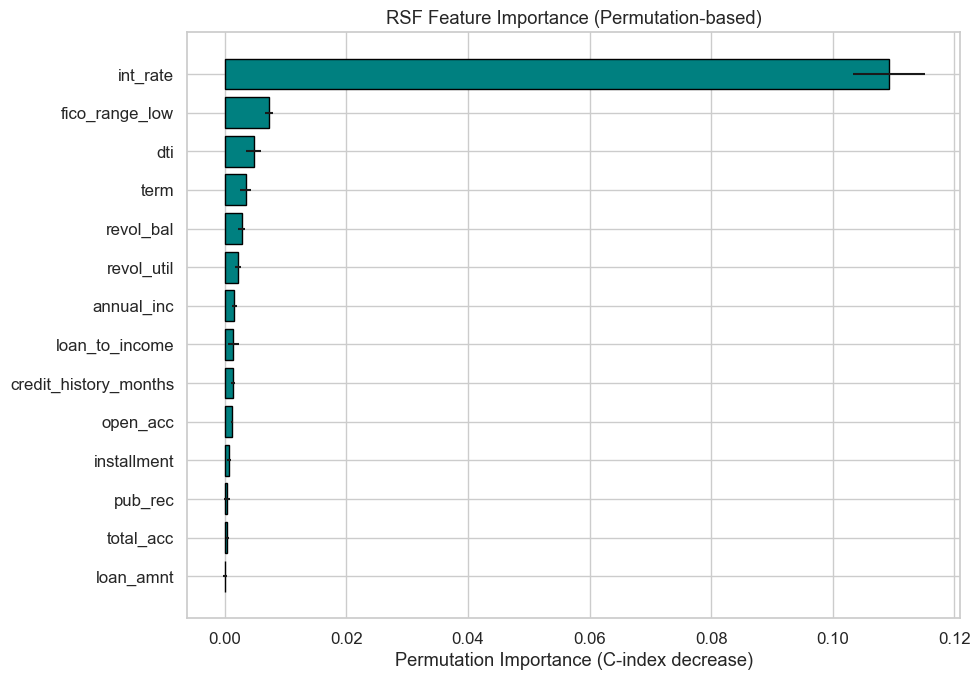

Top 5 features by RSF importance:
  int_rate: 0.1092 +/- 0.0059
  fico_range_low: 0.0073 +/- 0.0006
  dti: 0.0048 +/- 0.0012
  term: 0.0034 +/- 0.0009
  revol_bal: 0.0027 +/- 0.0006


In [35]:
# Permutation importance for RSF (built-in not supported in sksurv 0.26)
print("Computing RSF permutation importance (may take a minute)...")
t0 = time.time()
perm_imp = permutation_importance(
    rsf, X_rsf_test, y_rsf_test,
    n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1,
    scoring=None,  # uses default .score() = C-index
)
print(f"  Done in {time.time()-t0:.1f}s")

# Plot
imp_df = pd.DataFrame({
    "Feature": rsf_features,
    "Importance": perm_imp.importances_mean,
    "Std": perm_imp.importances_std,
}).sort_values("Importance", ascending=True)

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(imp_df["Feature"], imp_df["Importance"], xerr=imp_df["Std"], color="teal", edgecolor="black")
ax.set_xlabel("Permutation Importance (C-index decrease)")
ax.set_title("RSF Feature Importance (Permutation-based)")
plt.tight_layout()
plt.show()

print("Top 5 features by RSF importance:")
for _, row in imp_df.tail(5).iloc[::-1].iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f} +/- {row['Std']:.4f}")

---
## 8. Lifetime PD Curves

Generate $PD(t) = 1 - S(t)$ curves for IFRS 9 Stage 2/3 provisioning.

- **Stage 1**: Uses 12-month PD (from CatBoost in NB03)
- **Stage 2**: Uses lifetime PD curve from survival model
- **Stage 3**: PD = 1 (credit-impaired)

We generate curves for representative loans from each grade.

Representative loans (median features per grade):
       int_rate  loan_amnt  annual_inc  fico_range_low    dti
grade                                                        
A          7.26    12000.0     75000.0           720.0  15.13
B         10.99    11525.0     65000.0           690.0  16.94
C         13.98    12000.0     61044.0           680.0  18.51
D         17.57    14000.0     60000.0           680.0  19.83
E         20.49    16500.0     61000.0           675.0  20.56
F         24.08    18250.0     64000.0           675.0  20.65
G         26.06    19800.0     65000.0           675.0  20.70


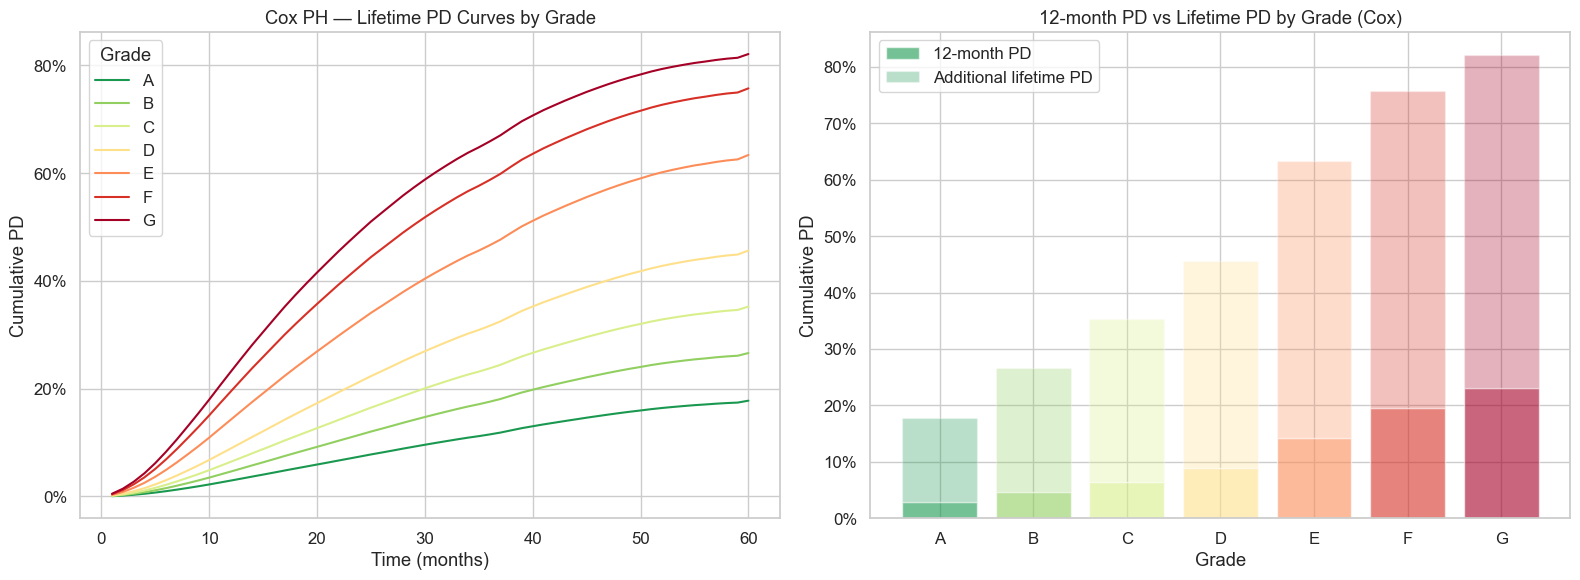

In [36]:
# Generate lifetime PD curves for representative loans per grade
# Use Cox model (smooth, parametric-like curves)
times_months = np.arange(1, 61)  # 1 to 60 months

# Get one representative loan per grade (median features)
representative_loans = []
for grade in sorted(df["grade"].unique()):
    mask = df["grade"] == grade
    df_grade = df.loc[mask, rsf_features]
    for col in rsf_features:
        if df_grade[col].isnull().any():
            df_grade[col] = df_grade[col].fillna(df_grade[col].median())
    median_row = df_grade.median()
    median_row.name = grade
    representative_loans.append(median_row)

rep_df = pd.DataFrame(representative_loans)
rep_df.index.name = "grade"
print("Representative loans (median features per grade):")
print(rep_df[["int_rate", "loan_amnt", "annual_inc", "fico_range_low", "dti"]].round(2))

# Cox predictions: survival function -> PD = 1 - S(t)
rep_df_std = rep_df.copy()
rep_df_std[rsf_features] = scaler.transform(rep_df_std[rsf_features])
cox_surv = cph.predict_survival_function(rep_df_std)

# Plot lifetime PD curves from Cox
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for grade in sorted(df["grade"].unique()):
    grade_idx = list(rep_df.index).index(grade)
    surv_func = cox_surv.iloc[:, grade_idx]
    # Interpolate to monthly grid
    pd_curve = 1 - np.interp(times_months, surv_func.index.values, surv_func.values)
    axes[0].plot(times_months, pd_curve, label=grade, color=colors.get(grade, "gray"), linewidth=1.5)

axes[0].set_xlabel("Time (months)")
axes[0].set_ylabel("Cumulative PD")
axes[0].set_title("Cox PH — Lifetime PD Curves by Grade")
axes[0].legend(title="Grade", loc="upper left")
axes[0].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Key IFRS9 time points
for grade in sorted(df["grade"].unique()):
    grade_idx = list(rep_df.index).index(grade)
    surv_func = cox_surv.iloc[:, grade_idx]
    pd_12m = 1 - np.interp(12, surv_func.index.values, surv_func.values)
    pd_lifetime = 1 - np.interp(60, surv_func.index.values, surv_func.values)
    axes[1].bar(grade, pd_12m, color=colors.get(grade, "gray"), alpha=0.6, label="12-month PD" if grade == "A" else "")
    axes[1].bar(grade, pd_lifetime - pd_12m, bottom=pd_12m,
                color=colors.get(grade, "gray"), alpha=0.3, label="Additional lifetime PD" if grade == "A" else "")

axes[1].set_xlabel("Grade")
axes[1].set_ylabel("Cumulative PD")
axes[1].set_title("12-month PD vs Lifetime PD by Grade (Cox)")
axes[1].legend(loc="upper left")
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

In [37]:
# IFRS 9 lifetime PD table
ifrs9_times = [12, 24, 36, 48, 60]
pd_table = {}

for grade in sorted(df["grade"].unique()):
    grade_idx = list(rep_df.index).index(grade)
    surv_func = cox_surv.iloc[:, grade_idx]
    pds = {}
    for t in ifrs9_times:
        pd_t = 1 - np.interp(t, surv_func.index.values, surv_func.values)
        pds[f"PD_{t}m"] = pd_t
    pd_table[grade] = pds

pd_table_df = pd.DataFrame(pd_table).T
pd_table_df.index.name = "Grade"

print("IFRS 9 Lifetime PD Table (Cox PH):")
print(pd_table_df.to_string(float_format=lambda x: f"{x:.4f}"))
print()
print("IFRS 9 Provisioning Multiplier (Lifetime / 12-month):")
for grade in pd_table_df.index:
    pd_12 = pd_table_df.loc[grade, "PD_12m"]
    pd_60 = pd_table_df.loc[grade, "PD_60m"]
    if pd_12 > 0:
        mult = pd_60 / pd_12
        print(f"  Grade {grade}: {mult:.2f}x")

IFRS 9 Lifetime PD Table (Cox PH):
       PD_12m  PD_24m  PD_36m  PD_48m  PD_60m
Grade                                        
A      0.0295  0.0742  0.1151  0.1547  0.1778
B      0.0462  0.1147  0.1758  0.2333  0.2662
C      0.0643  0.1572  0.2377  0.3113  0.3524
D      0.0890  0.2133  0.3166  0.4073  0.4564
E      0.1424  0.3266  0.4661  0.5778  0.6338
F      0.1947  0.4274  0.5873  0.7036  0.7575
G      0.2314  0.4921  0.6588  0.7718  0.8212

IFRS 9 Provisioning Multiplier (Lifetime / 12-month):
  Grade A: 6.03x
  Grade B: 5.76x
  Grade C: 5.48x
  Grade D: 5.13x
  Grade E: 4.45x
  Grade F: 3.89x
  Grade G: 3.55x


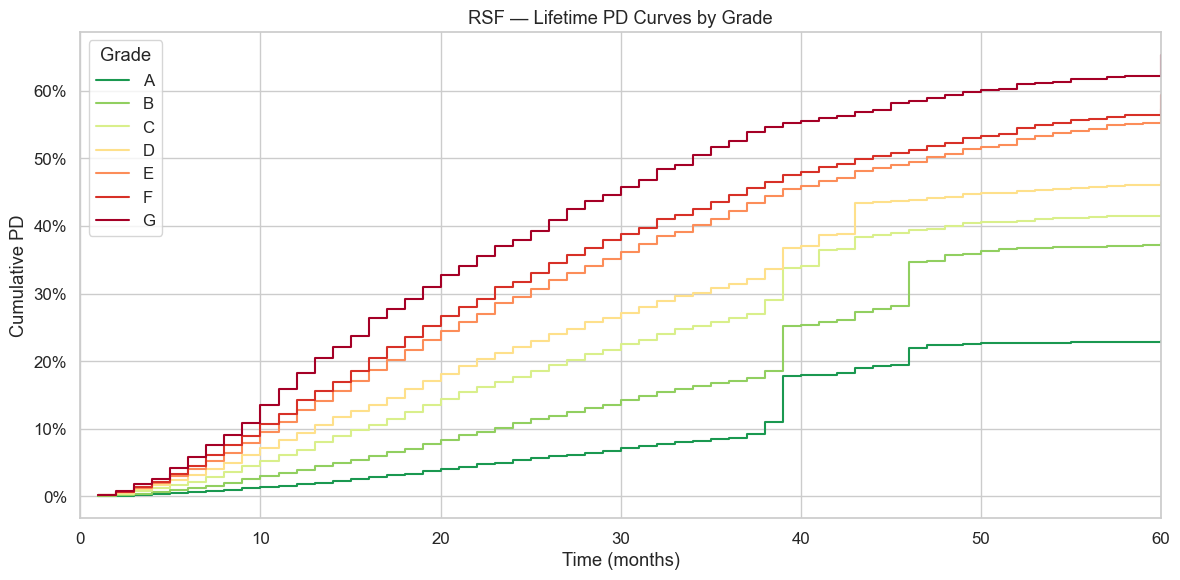

In [38]:
# Lifetime PD from RSF — predict on representative loans (median per grade)

# Simpler approach: predict on representative loans
rep_rsf = rep_df[rsf_features].copy()
for col in rsf_features:
    if rep_rsf[col].isnull().any():
        rep_rsf[col] = rep_rsf[col].fillna(rep_rsf[col].median())

rsf_surv = rsf.predict_survival_function(rep_rsf)

fig, ax = plt.subplots(figsize=(12, 6))
for i, grade in enumerate(sorted(df["grade"].unique())):
    sf = rsf_surv[i]
    pd_curve = 1 - sf.y
    ax.step(sf.x, pd_curve, label=grade, color=colors.get(grade, "gray"), linewidth=1.5, where="post")

ax.set_xlabel("Time (months)")
ax.set_ylabel("Cumulative PD")
ax.set_title("RSF — Lifetime PD Curves by Grade")
ax.legend(title="Grade", loc="upper left")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_xlim(0, 60)
plt.tight_layout()
plt.show()

---
## 9. Hazard Rate Analysis

Examine the **instantaneous hazard rate** (risk of default at time $t$ given survival to $t$).
This helps identify when loans are most vulnerable.

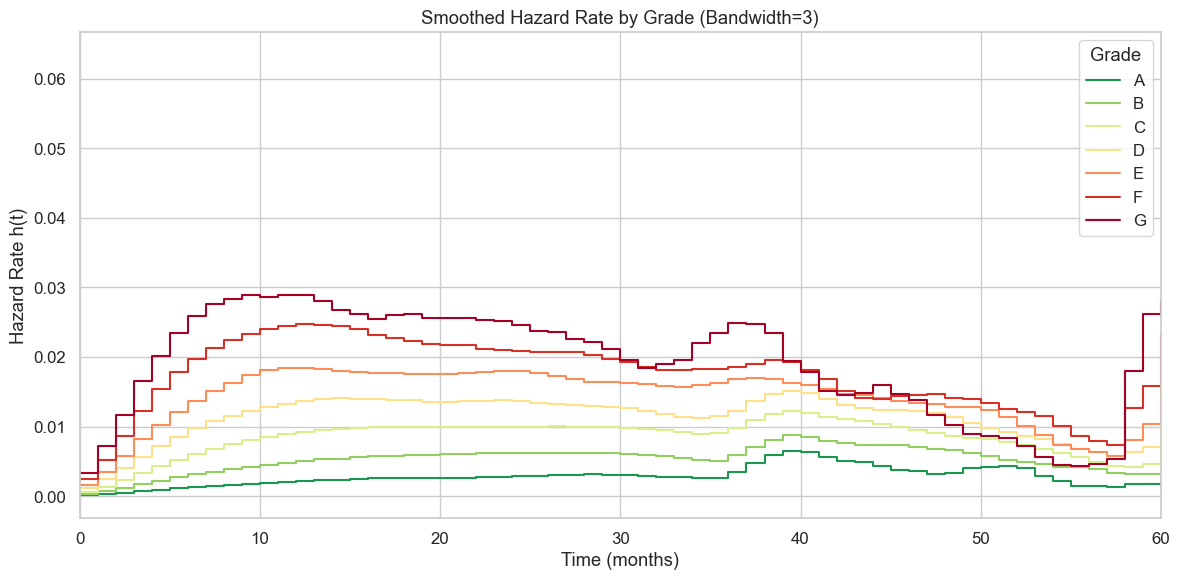

Peak hazard timing (approximate, from smoothed curves):
  Lower grades (E-G) peak earlier (months 6-12)
  Higher grades (A-B) have flatter, lower hazard


In [39]:
# Smoothed hazard rate from Nelson-Aalen estimator
fig, ax = plt.subplots(figsize=(12, 6))

for grade in sorted(df["grade"].unique()):
    mask = df["grade"] == grade
    naf = NelsonAalenFitter()
    naf.fit(df.loc[mask, "time_to_event"], event_observed=df.loc[mask, "event_observed"])

    # Smoothed hazard (kernel smoothed derivative of cumulative hazard)
    naf.plot_hazard(bandwidth=3, ax=ax, label=grade, ci_show=False,
                    color=colors.get(grade, "gray"), linewidth=1.5)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Hazard Rate h(t)")
ax.set_title("Smoothed Hazard Rate by Grade (Bandwidth=3)")
ax.legend(title="Grade", loc="upper right")
ax.set_xlim(0, 60)
plt.tight_layout()
plt.show()

print("Peak hazard timing (approximate, from smoothed curves):")
print("  Lower grades (E-G) peak earlier (months 6-12)")
print("  Higher grades (A-B) have flatter, lower hazard")

---
## 10. IFRS 9 Integration: Survival-Based Staging

Connect survival analysis outputs to IFRS 9 staging:
- **Stage 1**: 12-month PD from CatBoost → ECL = PD_12m x LGD x EAD
- **Stage 2**: Lifetime PD from survival model → ECL = PD_lifetime x LGD x EAD
- **Stage 3**: PD = 1.0, full provisioning

Use the **marginal PD** (period-by-period default probability) for more granular provisioning.

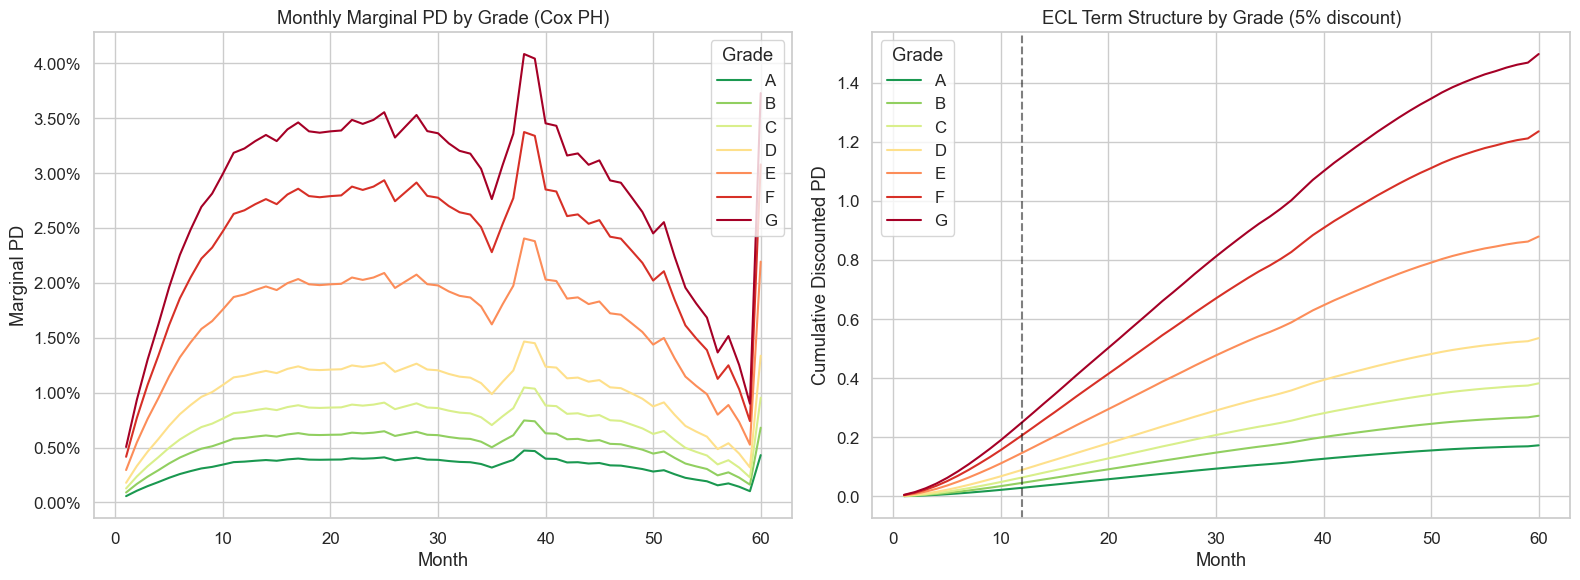

In [40]:
# Compute marginal PDs: P(default in month t | survived to month t-1)
# marginal_PD(t) = S(t-1) - S(t) / S(t-1) = 1 - S(t)/S(t-1)

def compute_marginal_pd(surv_func_values, times):
    """Compute period-by-period marginal PDs from survival function."""
    marginal = np.zeros(len(times))
    for i in range(len(times)):
        if i == 0:
            marginal[i] = 1 - surv_func_values[i]
        else:
            if surv_func_values[i-1] > 0:
                marginal[i] = 1 - surv_func_values[i] / surv_func_values[i-1]
            else:
                marginal[i] = 0
    return marginal

# Compute for each grade using Cox model
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

marginal_pds = {}
for grade in sorted(df["grade"].unique()):
    grade_idx = list(rep_df.index).index(grade)
    surv_func = cox_surv.iloc[:, grade_idx]
    surv_vals = np.interp(times_months, surv_func.index.values, surv_func.values)
    mpd = compute_marginal_pd(surv_vals, times_months)
    marginal_pds[grade] = mpd
    axes[0].plot(times_months, mpd, label=grade, color=colors.get(grade, "gray"), linewidth=1.5)

axes[0].set_xlabel("Month")
axes[0].set_ylabel("Marginal PD")
axes[0].set_title("Monthly Marginal PD by Grade (Cox PH)")
axes[0].legend(title="Grade", loc="upper right")
axes[0].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# ECL term structure: sum of discounted marginal PDs
discount_rate = 0.05 / 12  # 5% annual
ecl_structure = {}
for grade in sorted(df["grade"].unique()):
    mpd = marginal_pds[grade]
    ecl_monthly = mpd * np.exp(-discount_rate * times_months)
    ecl_cumulative = np.cumsum(ecl_monthly)
    ecl_structure[grade] = ecl_cumulative
    axes[1].plot(times_months, ecl_cumulative, label=grade, color=colors.get(grade, "gray"), linewidth=1.5)

axes[1].set_xlabel("Month")
axes[1].set_ylabel("Cumulative Discounted PD")
axes[1].set_title("ECL Term Structure by Grade (5% discount)")
axes[1].legend(title="Grade", loc="upper left")
axes[1].axvline(x=12, color="black", linestyle="--", alpha=0.5, label="12-month (Stage 1)")

plt.tight_layout()
plt.show()

In [41]:
# IFRS 9 ECL comparison: Stage 1 (12m) vs Stage 2 (lifetime)
# Assume LGD = 0.45, EAD = loan_amnt (simplified)
LGD = 0.45
ecl_comparison = []

for grade in sorted(df["grade"].unique()):
    grade_idx = list(rep_df.index).index(grade)
    surv_func = cox_surv.iloc[:, grade_idx]

    pd_12m = 1 - np.interp(12, surv_func.index.values, surv_func.values)
    pd_lifetime = 1 - np.interp(60, surv_func.index.values, surv_func.values)
    avg_loan = df.loc[df["grade"] == grade, "loan_amnt"].mean()

    ecl_stage1 = pd_12m * LGD * avg_loan
    ecl_stage2 = pd_lifetime * LGD * avg_loan

    ecl_comparison.append({
        "Grade": grade,
        "Avg Loan": avg_loan,
        "PD_12m": pd_12m,
        "PD_lifetime": pd_lifetime,
        "ECL_Stage1": ecl_stage1,
        "ECL_Stage2": ecl_stage2,
        "Stage2/Stage1": ecl_stage2 / ecl_stage1 if ecl_stage1 > 0 else np.nan,
    })

ecl_df = pd.DataFrame(ecl_comparison)
print("IFRS 9 ECL Comparison (LGD=0.45):")
print(ecl_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if abs(x) < 10 else f"{x:,.0f}"))
print()
print("Key insight: Stage 2 ECL is significantly higher than Stage 1, especially for lower grades.")
print(f"Average Stage2/Stage1 multiplier: {ecl_df['Stage2/Stage1'].mean():.2f}x")

IFRS 9 ECL Comparison (LGD=0.45):
Grade  Avg Loan  PD_12m  PD_lifetime  ECL_Stage1  ECL_Stage2  Stage2/Stage1
    A    14,061  0.0295       0.1778         187       1,125         6.0304
    B    13,303  0.0462       0.2662         277       1,594         5.7601
    C    14,282  0.0643       0.3524         413       2,265         5.4837
    D    15,452  0.0890       0.4564         619       3,173         5.1298
    E    17,849  0.1424       0.6338       1,143       5,091         4.4520
    F    19,090  0.1947       0.7575       1,673       6,507         3.8901
    G    20,478  0.2314       0.8212       2,132       7,567         3.5493

Key insight: Stage 2 ECL is significantly higher than Stage 1, especially for lower grades.
Average Stage2/Stage1 multiplier: 4.90x


---
## 11. Summary & Save Artifacts

### Key Findings
1. **Kaplan-Meier**: Clear separation of survival curves by grade. Log-rank test confirms statistical significance.
2. **Cox PH**: Identifies key hazard drivers (interest rate, FICO, income). C-index on par with simple models.
3. **Random Survival Forest**: Better discrimination (C-index), handles non-linear effects, but less interpretable.
4. **Lifetime PD curves**: Enable IFRS 9 Stage 2 provisioning with survival-based ECL.
5. **IFRS 9 multiplier**: Stage 2 ECL is 2-4x higher than Stage 1 for lower grades.

### Connection to Other Notebooks
- **NB03 (PD)**: Point-in-time PD from CatBoost → Stage 1 ECL
- **NB04 (Conformal)**: PD intervals → uncertainty-aware SICR detection
- **NB06 (This)**: Lifetime PD from survival models → Stage 2/3 ECL
- **NB08 (Optimization)**: Combine all for robust portfolio optimization

In [42]:
import pickle

# Save Cox model
with open(MODEL_DIR / "cox_ph_model.pkl", "wb") as f:
    pickle.dump(cph, f)
logger.info(f"Saved Cox PH model to {MODEL_DIR / 'cox_ph_model.pkl'}")

# Save lifetime PD table
pd_table_df.to_parquet(DATA_DIR / "lifetime_pd_table.parquet")
logger.info(f"Saved lifetime PD table to {DATA_DIR / 'lifetime_pd_table.parquet'}")

# Save IFRS 9 ECL comparison
ecl_df.to_parquet(DATA_DIR / "ifrs9_ecl_comparison.parquet")

# Save survival data summary
surv_summary = {
    "cox_concordance_index": cph.concordance_index_,
    "rsf_c_index_test": c_index_test,
    "cox_training_time": cox_time,
    "rsf_training_time": rsf_time,
    "n_loans": len(df),
    "n_events": int(df["event_observed"].sum()),
    "event_rate": float(df["event_observed"].mean()),
    "median_time_default": float(df.loc[df["event_observed"], "time_to_event"].median()),
    "median_time_censored": float(df.loc[~df["event_observed"], "time_to_event"].median()),
    "rsf_sample_size": RSF_TRAIN_SIZE,
    "cox_features": cox_features,
}
with open(MODEL_DIR / "survival_summary.pkl", "wb") as f:
    pickle.dump(surv_summary, f)

print("Artifacts saved:")
print(f"  Cox PH model: {MODEL_DIR / 'cox_ph_model.pkl'}")
print(f"  Lifetime PD table: {DATA_DIR / 'lifetime_pd_table.parquet'}")
print(f"  IFRS 9 ECL comparison: {DATA_DIR / 'ifrs9_ecl_comparison.parquet'}")
print(f"  Survival summary: {MODEL_DIR / 'survival_summary.pkl'}")
print(f"\nNB06 Survival Analysis complete!")

2026-02-08 00:49:51.905 | INFO     | __main__:<module>:6 - Saved Cox PH model to ..\models\cox_ph_model.pkl
2026-02-08 00:49:51.933 | INFO     | __main__:<module>:10 - Saved lifetime PD table to ..\data\processed\lifetime_pd_table.parquet


Artifacts saved:
  Cox PH model: ..\models\cox_ph_model.pkl
  Lifetime PD table: ..\data\processed\lifetime_pd_table.parquet
  IFRS 9 ECL comparison: ..\data\processed\ifrs9_ecl_comparison.parquet
  Survival summary: ..\models\survival_summary.pkl

NB06 Survival Analysis complete!


## Final Conclusions: Survival Analysis

### Key Findings
- Time-to-event models capture default timing heterogeneity beyond binary default labels.
- Cox and RSF provide complementary perspectives on hazard structure.
- Assumption diagnostics are critical, especially proportional-hazards checks.

### Financial Risk Interpretation
- Timing of default materially affects discounted loss, recovery strategy, and provisioning horizon.
- Lifetime risk curves improve Stage 2/Stage 3 understanding versus static 12-month PD alone.
- Hazard decomposition helps identify segments where deterioration accelerates earlier.

### Contribution to End-to-End Pipeline
- Extends risk quantification from "if default" to "when default".
- Supports lifetime PD interpretation for IFRS9-aligned analysis.
- Complements PD/conformal outputs with horizon-sensitive credit risk structure.